In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sns
import copy

from torch.utils.data import DataLoader
import transformer_lens
import datasets

from sparse_probing_paper.load import *

from sparse_probing_paper.analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df
)

from sparse_probing_paper.analysis.plots import *


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [11]:
total_time = 62
f'Finished in {total_time / 60 :.2f} seconds of which'

'Finished in 1.03 seconds of which'

In [3]:


results_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results'
sizes = ['19m', '125m', '350m', '800m', '1.3b']
all_results = []
for s in sizes:
    results_dict = load_probing_experiment_results(results_dir, 'text_features_test', 'heuristic_sparsity_sweep', f'pythia-{s}')
    rdf = make_heuristic_probing_results_df(results_dict)
    # add model size to index of rdf
    rdf.index = pd.MultiIndex.from_tuples([
        (s, *t) for t in rdf.index.values],
        names=['model_size', 'feature', 'layer', 'k']
    )
    all_results.append(rdf)
rdf = pd.concat(all_results)

In [9]:
rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(25)

test_acc test_balanced_acc  \
model_size feature                 layer k                               
19m        all_digits              0     1    0.9995          0.999688   
           contains_digit          0     1    0.9995          0.999688   
350m       contains_digit          0     1   0.99825          0.998908   
           all_digits              0     1   0.99825          0.998908   
125m       contains_all_whitespace 0     1  0.994333          0.991236   
350m       contains_all_whitespace 0     1  0.994333          0.991389   
           all_capitals            1     1  0.995167          0.994979   
1.3b       contains_digit          1     1  0.995583          0.990795   
           all_digits              1     1  0.995583          0.990795   
125m       all_digits              0     1  0.974667          0.956034   
           contains_digit          0     1  0.974667          0.956034   
           has_leading_space       0     1  0.873667          0.873187   
800m       contains_all_whitespace 0     1  0.990917          0.982963   
1.3b       contains_all_whitespace 0     1     0.966          0.949713   
800m       all_capitals            0     1     0.927          0.930798   
19m        has_leading_space       0     1  0.888667          0.888425   
125m       contains_whitespace     0     1   0.84225          0.844331   
350m       contains_all_whitespace 23    1   0.95675          0.938395   
19m        contains_whitespace     0     1   0.85225          0.853632   
125m       contains_digit          1     1     0.963          0.916353   
           all_digits              1     1  0.963083          0.916562   
800m       contains_whitespace     0     1   0.76375           0.76449   
19m        contains_all_whitespace 0     1   0.96875           0.92462   
1.3b       all_digits              18    1   0.94825          0.900068   
           contains_digit          18    1  0.948167          0.900173   

                                           test_precision test_recall  \
model_size feature                 layer k                              
19m        all_digits              0     1       0.997495         1.0   
           contains_digit          0     1       0.997495         1.0   
350m       contains_digit          0     1       0.991286         1.0   
           all_digits              0     1       0.991286         1.0   
125m       contains_all_whitespace 0     1       0.986025    0.986025   
350m       contains_all_whitespace 0     1       0.985626    0.986436   
           all_capitals            1     1       0.981767    0.994663   
1.3b       contains_digit          1     1       0.994915    0.982838   
           all_digits              1     1       0.994915    0.982838   
125m       all_digits              0     1       0.946467    0.925073   
           contains_digit          0     1       0.946467    0.925073   
           has_leading_space       0     1       0.965323    0.773907   
800m       contains_all_whitespace 0     1        0.98538    0.969585   
1.3b       contains_all_whitespace 0     1       0.911084    0.922318   
800m       all_capitals            0     1       0.759481    0.937192   
19m        has_leading_space       0     1       0.931002    0.838386   
125m       contains_whitespace     0     1       0.954653    0.724279   
350m       contains_all_whitespace 23    1       0.882494    0.907522   
19m        contains_whitespace     0     1       0.923197    0.773919   
125m       contains_digit          1     1       0.971401    0.838845   
           all_digits              1     1       0.971415    0.839263   
800m       contains_whitespace     0     1       0.794876    0.721822   
19m        contains_all_whitespace 0     1       0.994712     0.85039   
1.3b       all_digits              18    1       0.911163    0.820008   
           contains_digit          18    1       0.910358    0.820427   

                                           test_average_precision  \
mode

ValueError: RGBA values should be within 0-1 range

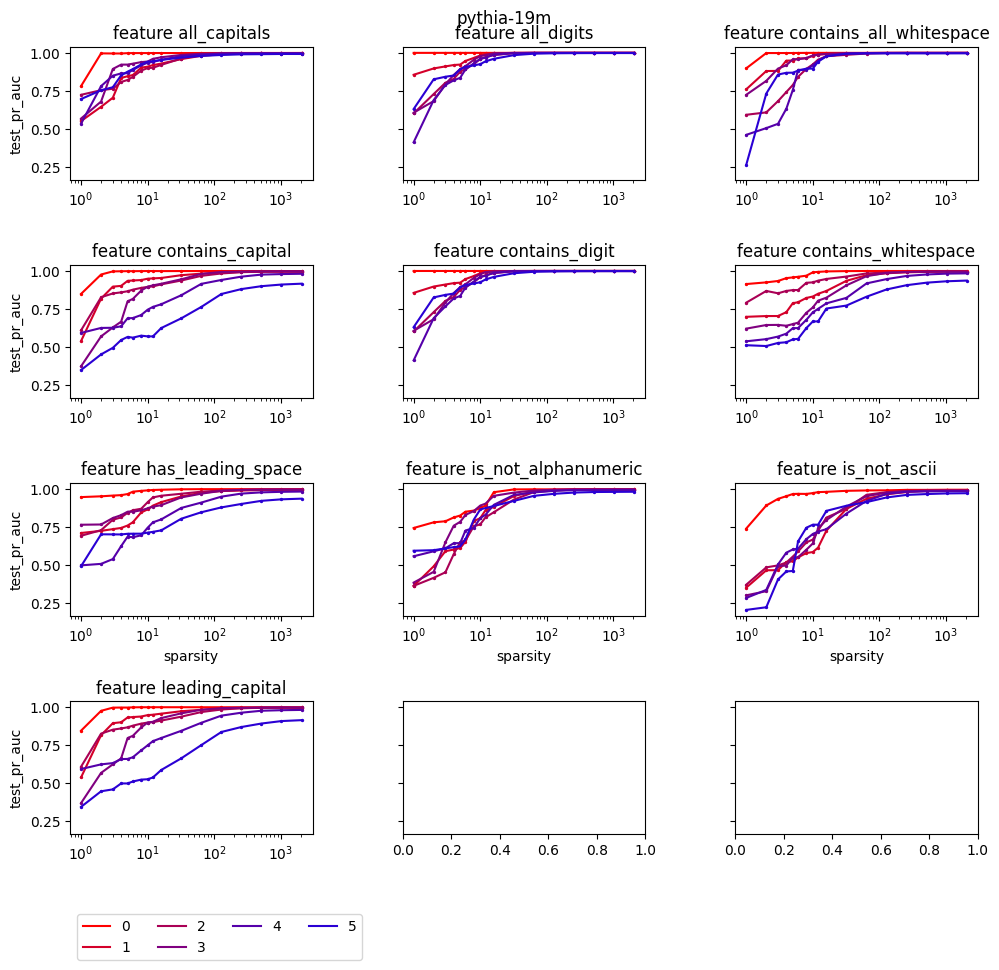

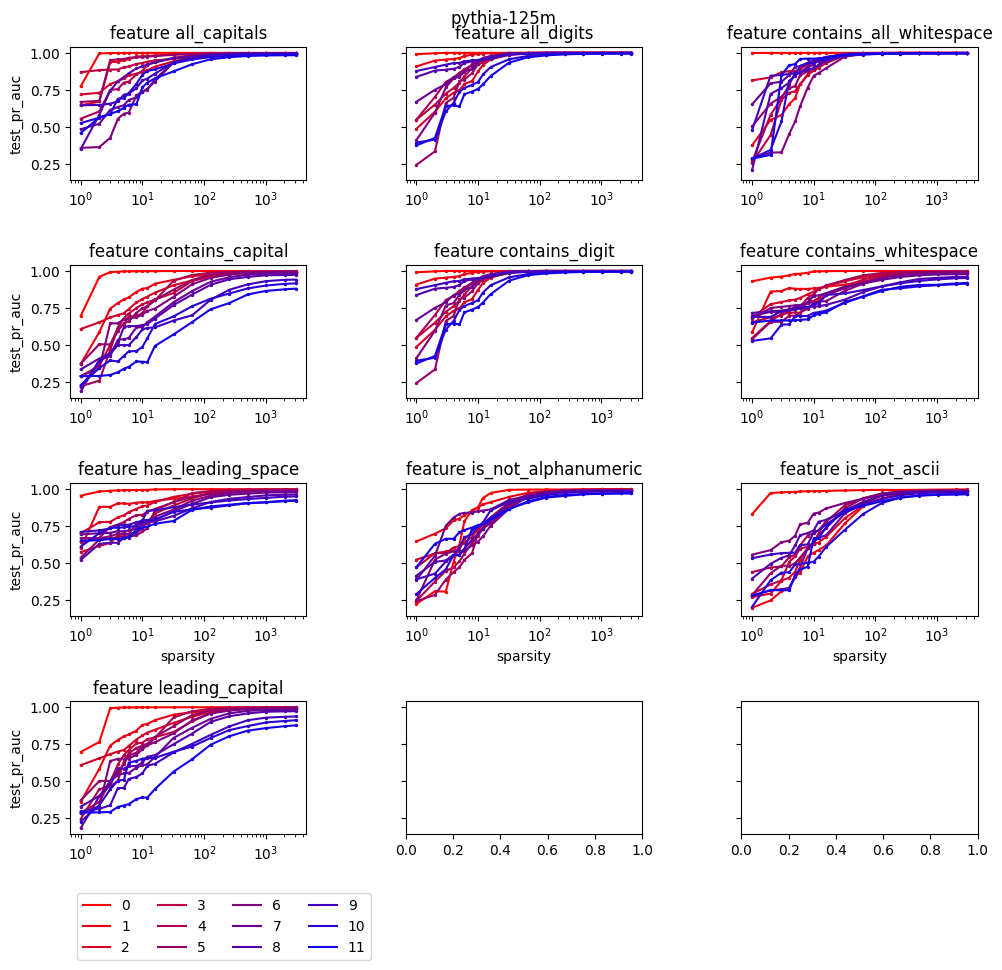

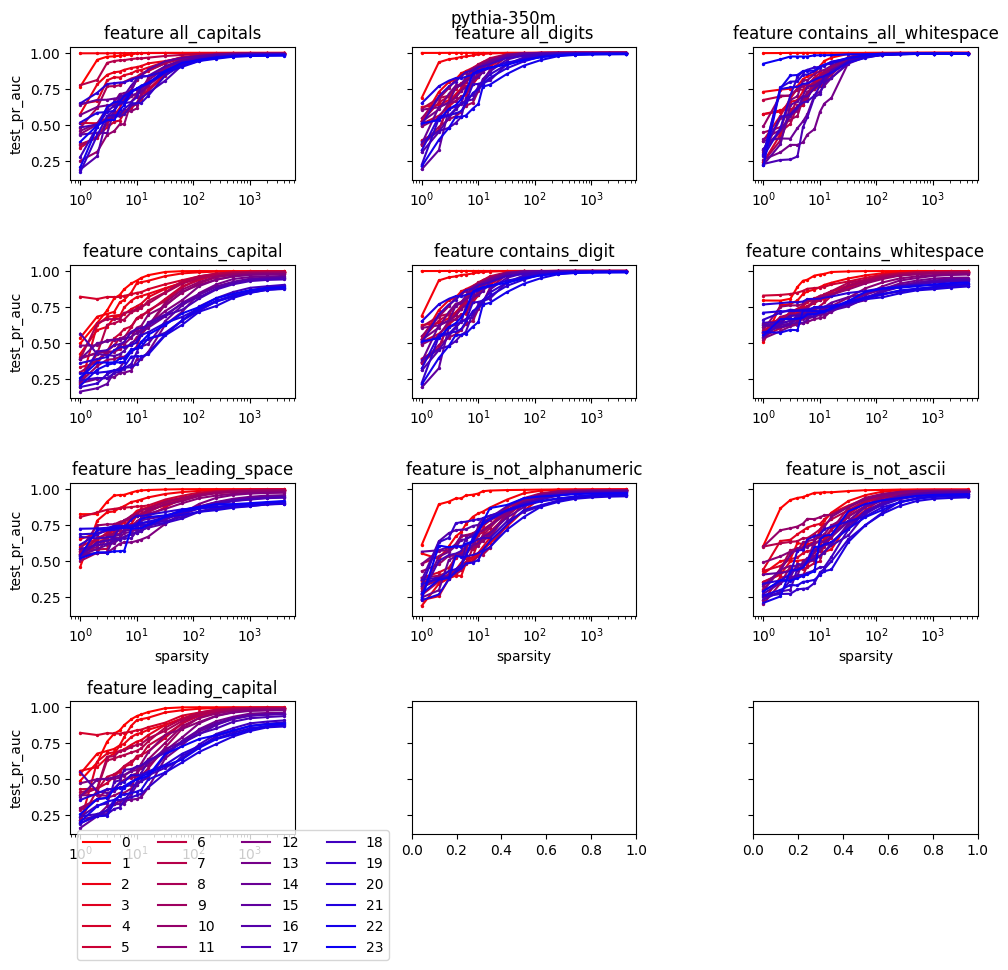

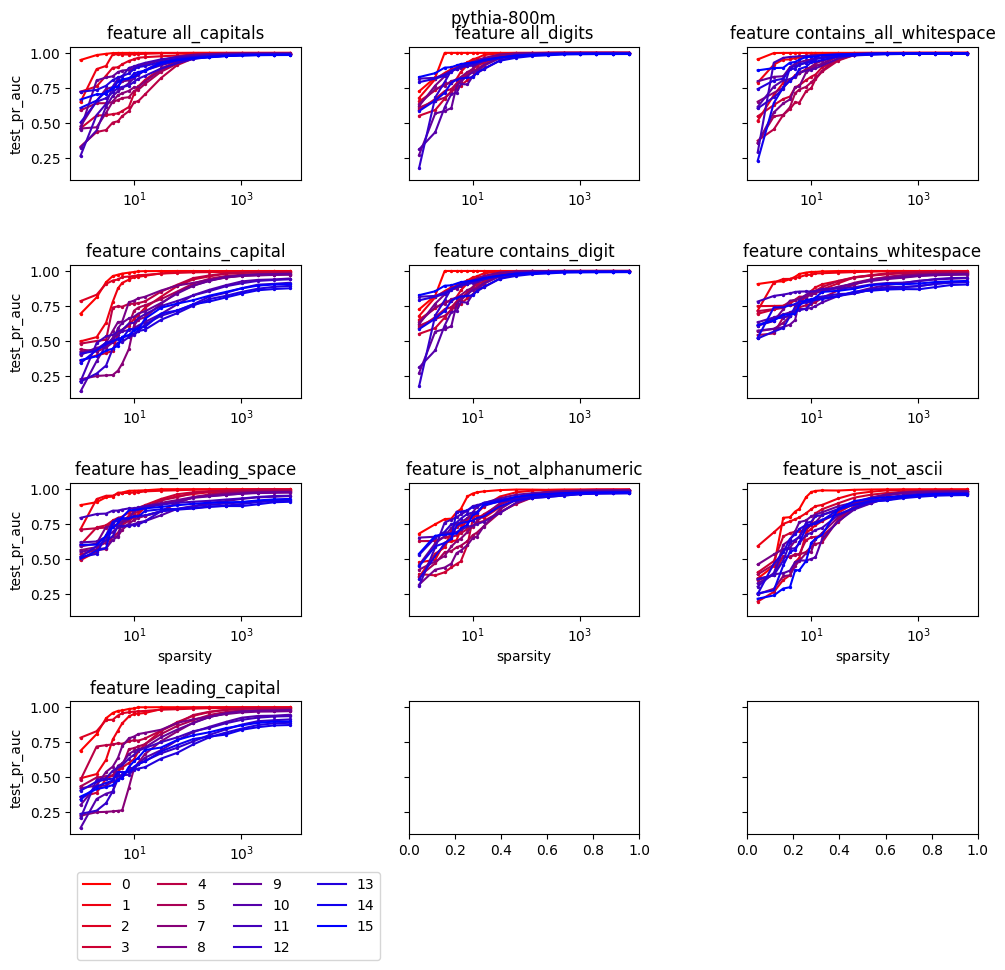

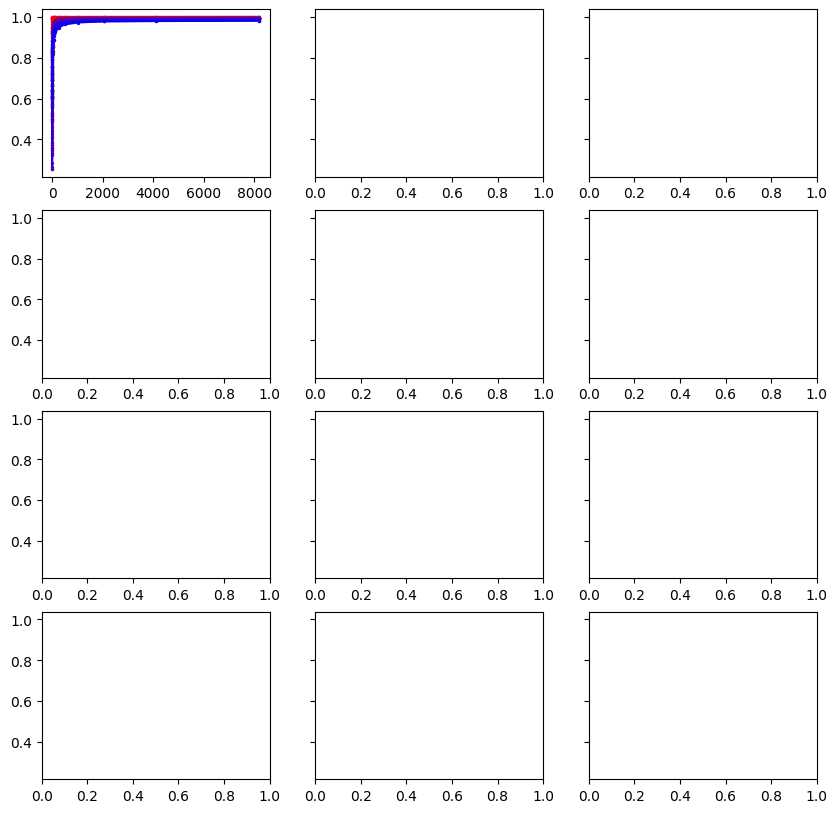

In [7]:
for s in sizes:
    plot_layer_metric_over_sparsity_per_feature(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)


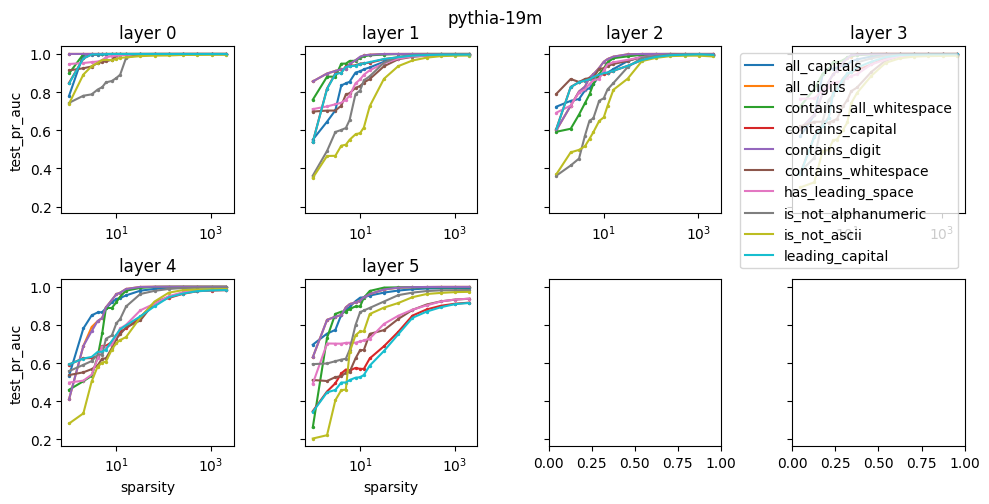

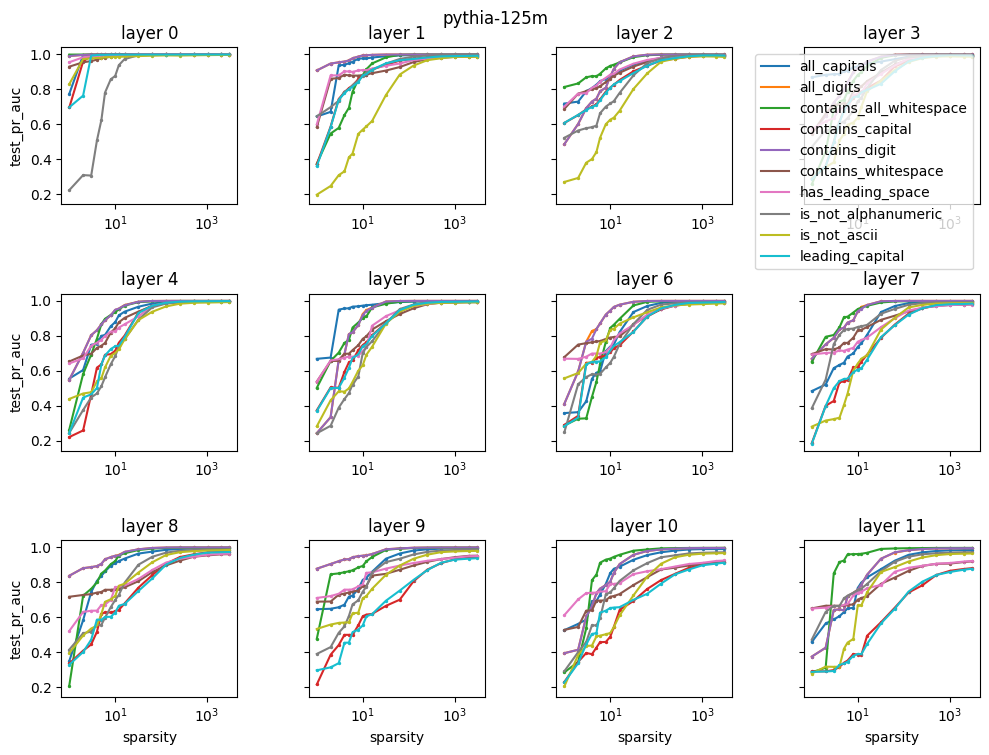

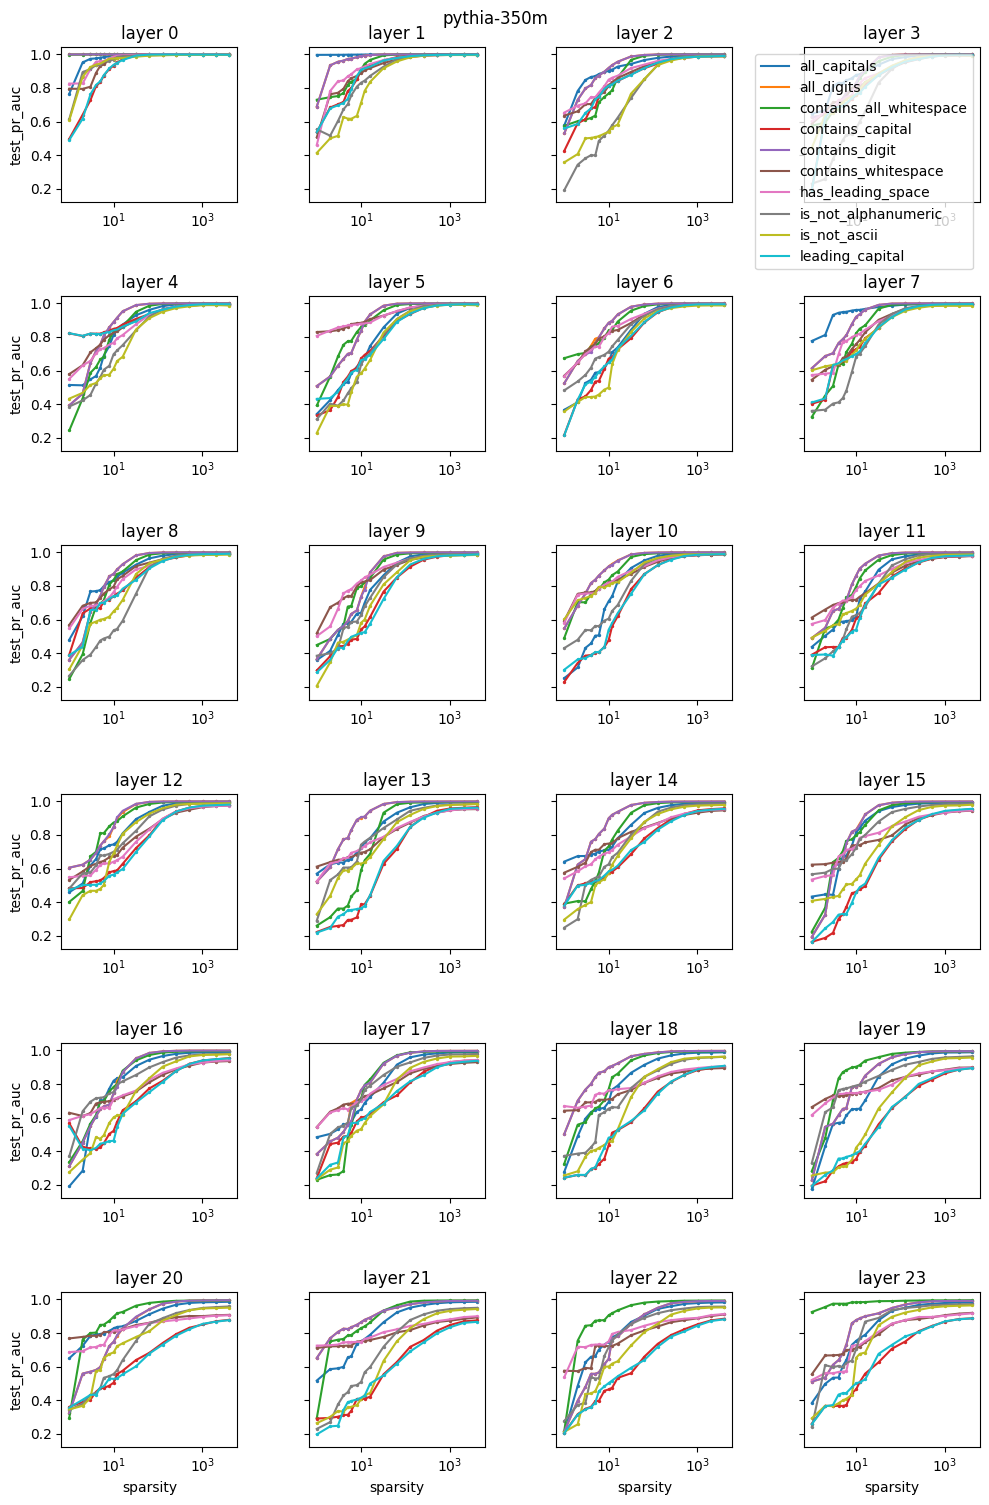

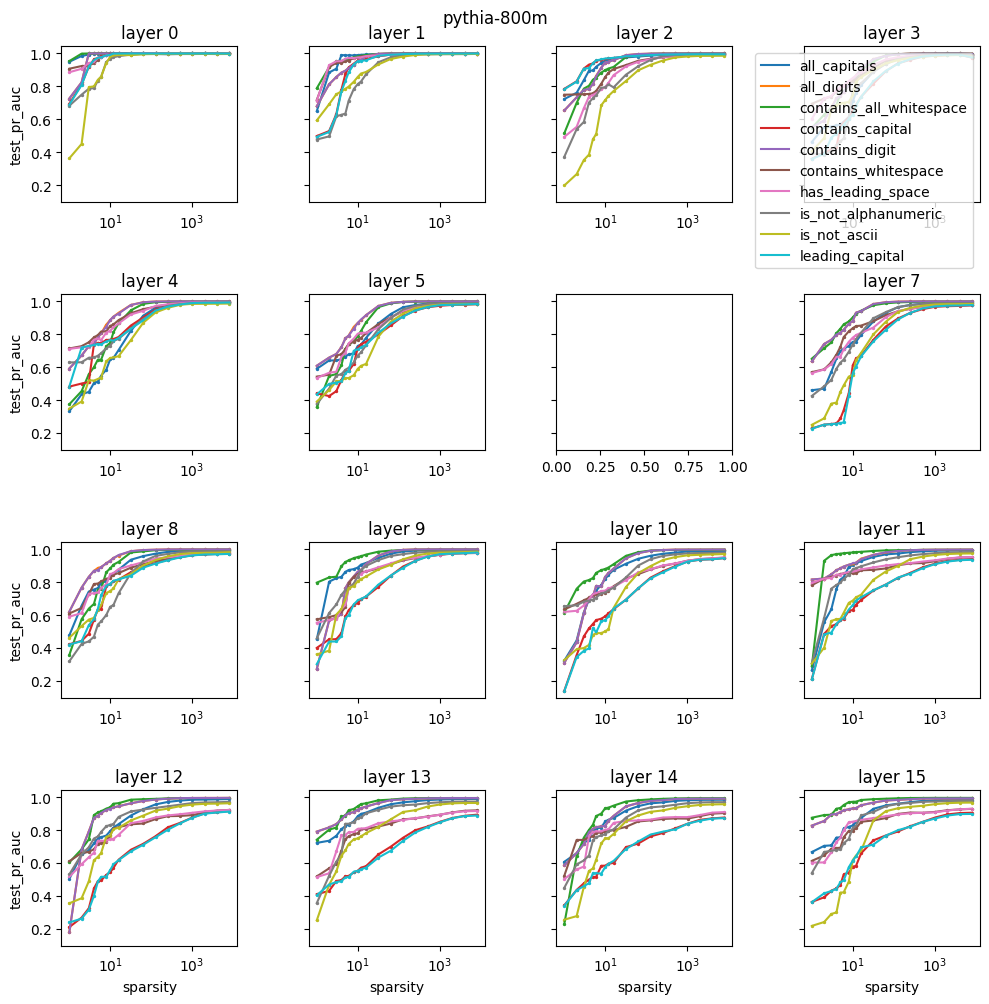

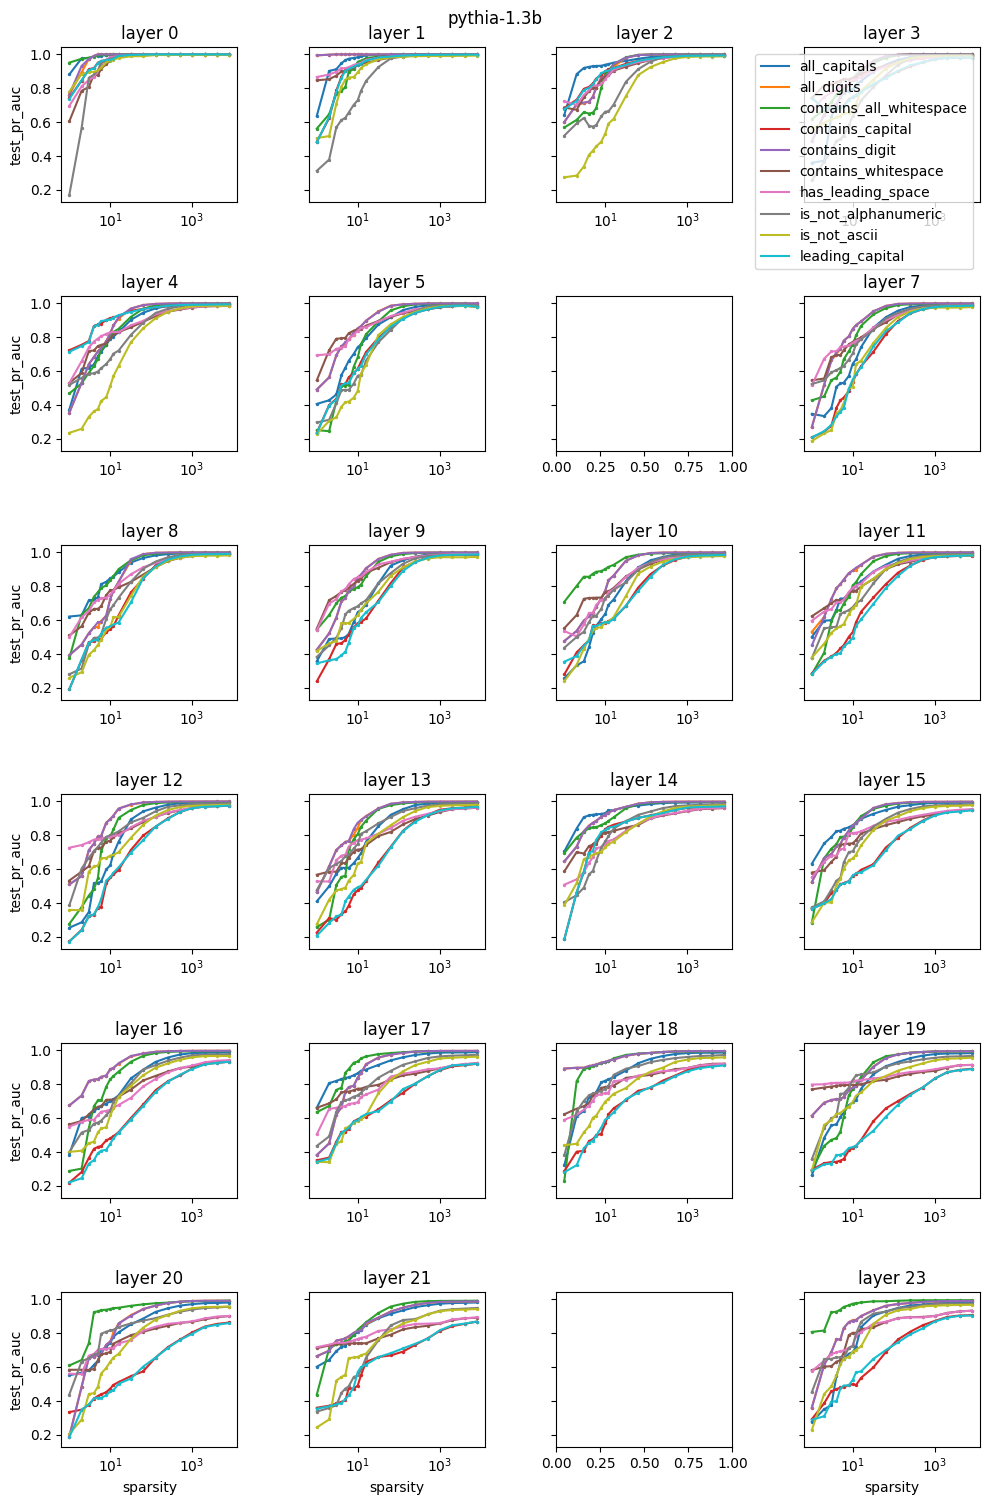

In [8]:
for s in sizes:
    plot_metric_over_sparsity_per_layer(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), 
    metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)

In [9]:
one_sp.head()

NameError: name 'one_sp' is not defined

In [ ]:
n_layers = rdf.reset_index().groupby('model_size').layer.max().to_dict()

one_sp = rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(10)
# plot one_sp for each feature:
# x axis: normalized layer depth
# y axis: test_pr_auc
# color: model size
def plot_model_k_sparse_performance_by_feature_and_depth(rdf, k, metric):
    features = rdf.index.get_level_values('feature').unique()
    fig, axs = plt.subplots(math.ceil(len(features) / 3), 3, figsize=(15, 10), sharey=True)
    for ix, f in enumerate(features):
        ax = axs[ix // 3, ix % 3]
        for s in sizes:
            line = rdf.loc[s, f, :, k][metric]
            y = line.values
            x = line.index / n_layers[s]
            ax.plot(x, y, label=s)
        
        ax.set_title(f)
        ax.set_xlabel('Normalized layer depth')
        ax.set_ylabel(metric)
    ax.legend()
    plt.tight_layout()
    plt.suptitle(f'Best {k}-sparse performance by feature and depth', y=1.02)

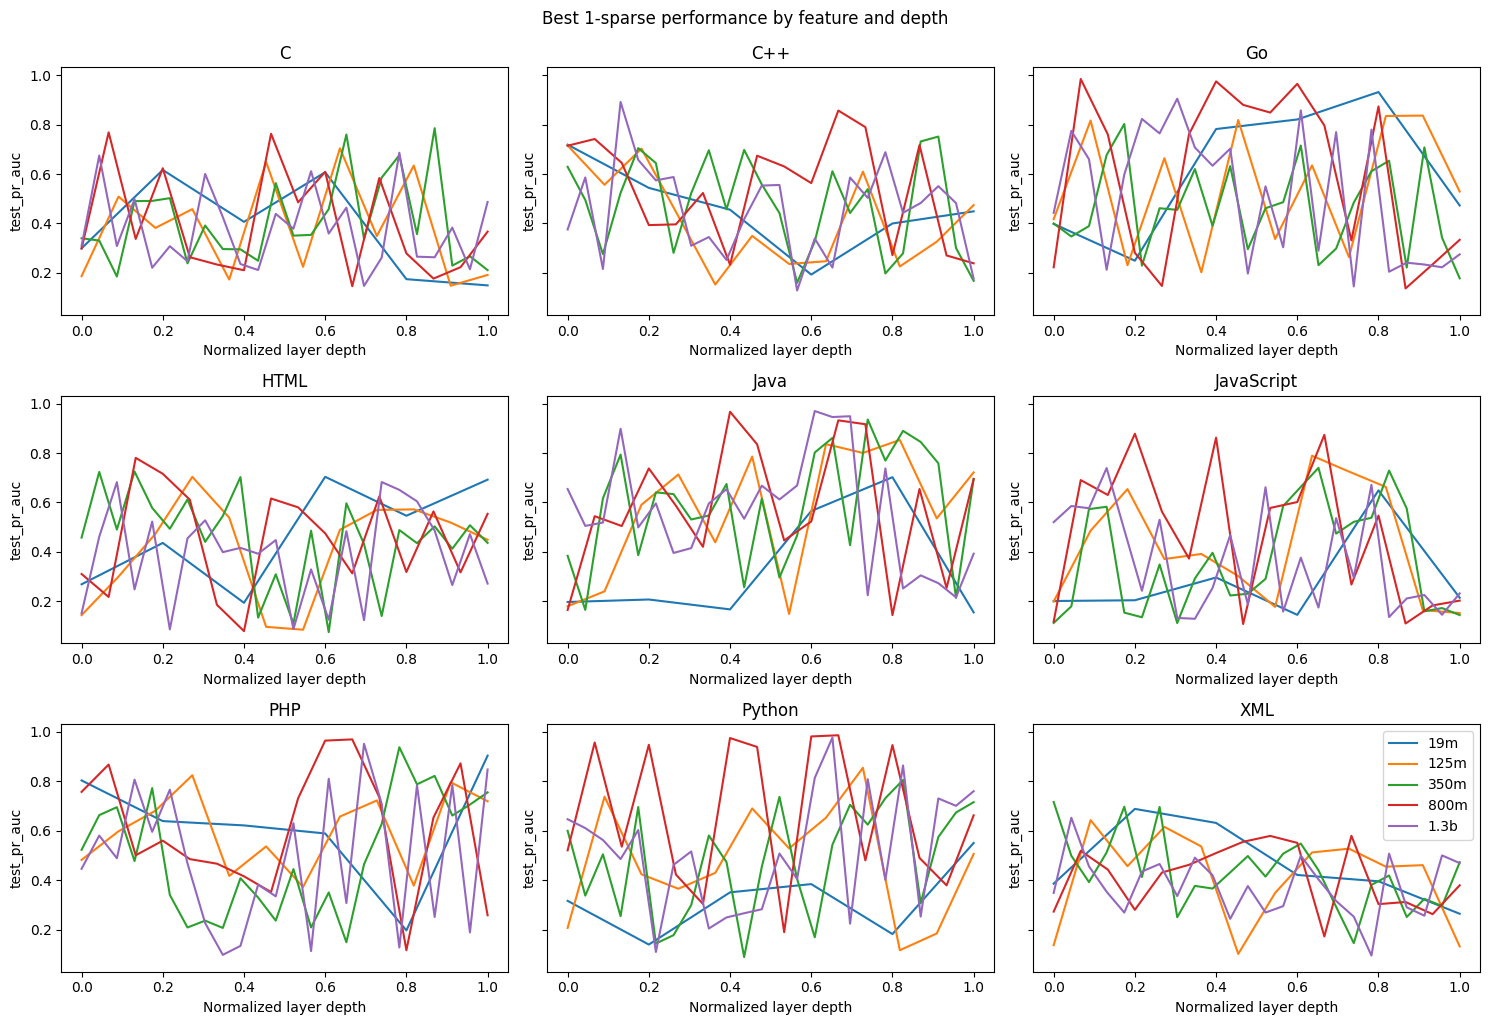

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 1, 'test_pr_auc')

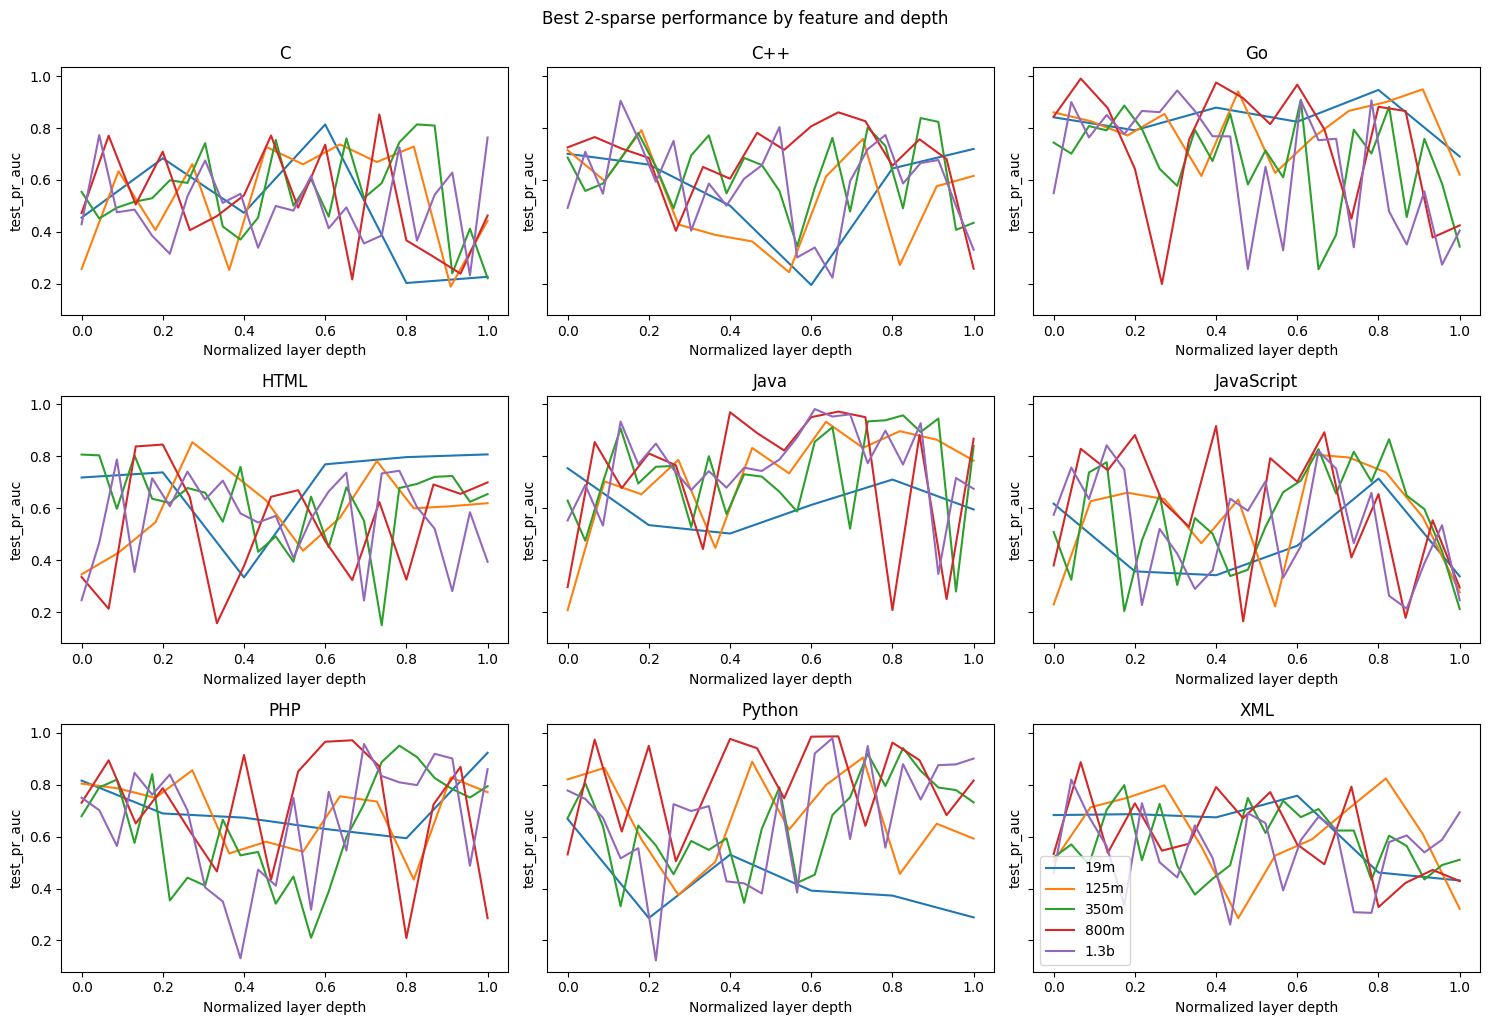

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 2, 'test_pr_auc')